In [1]:
import pickle
import copy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from experiments import *
from utils import *

In [9]:
splits = ['iid','noniid']

benchs = ['lb', 'mmlu', 'helm', 'alpaca','mmlu_fields']
titles = {'lb':'Open LLM Leaderboard','mmlu':'MMLU','helm':'HELM','alpaca':'AlpacaEval'}

agg = 'scenarios' # 'leaderboard', 'scenarios'
results = 'rank' # 'acc', 'rank'
agg_metric = 'avg' #'std' (std=variation across seeds)

if results == 'acc': ylim = (0,.1)
elif results == 'rank': 
    if agg_metric == 'std':
        ylim = (0,.1)
    else:
        ylim = (.5,1)
else: raise NotImplementedError

In [10]:
methods = ['random_naive', 'anchor_naive', 'anchor-irt_naive', #'anchor-irt_gpirt']
           #'random_pirt', 'anchor_pirt', 'anchor-irt_pirt']#,
           #'random_cirt','anchor_cirt', 'anchor-irt_cirt']#,
           'random_gpirt', 'anchor_gpirt', 'anchor-irt_gpirt']

In [11]:
table_avg = {}
table_std = {}
model_perf = {}
for bench in benchs:
    table_avg[bench] = {}
    table_std[bench] = {}
    model_perf[bench] = {}
        
    for split in splits:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}
        model_perf[bench][split] = {}
        

        with open(f'results/accs_{bench}_split-{split}_iterations-10.pickle', 'rb') as handle:
            data = pickle.load(handle)

        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
        scores = load_scores(bench, split)
        
        if agg == 'leaderboard':
            if bench=='helm': 
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = winrate(scores, axis=1).mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = winrate(data, axis=2).mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(winrate(data, axis=2).mean(axis=3)-winrate(scores, axis=1).mean(axis=0)[None,None,:,None])
                elif results == 'rank': 
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(winrate(data, axis=2).mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(winrate(data, axis=2).mean(axis=3)[i,j,:,l], winrate(scores.T, axis=0).mean(axis=1)).statistic
                    data=rank_corrs

                else: 
                    raise NotImplementedError
            else: 
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = scores.mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = data.mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(data.mean(axis=3)-scores.mean(axis=0)[None,None,:,None])
                elif results == 'rank': 
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(data.mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(data.mean(axis=3)[i,j,:,l], scores.T.mean(axis=1)).statistic
                    data=rank_corrs
                else: 
                    raise NotImplementedError
        elif agg == 'scenarios':
            if results == 'acc': 
                data = np.abs(data-scores.T[None,None,:,:,None]).mean(axis=3)
            elif results == 'rank': 
                rank_corrs = np.zeros(data.mean(axis=2).shape)
                for i in range(rank_corrs.shape[0]):
                    for j in range(rank_corrs.shape[1]):
                        for k in range(rank_corrs.shape[2]):
                            for l in range(rank_corrs.shape[3]):
                                rank_corrs[i,j,k,l] = stats.spearmanr(data[i,j,:,k,l], scores.T[:,k]).statistic
                data=rank_corrs
            else: 
                raise NotImplementedError
        else:
            raise NotImplementedError
            
        if agg_metric=='avg':
            data = data.mean(-1) #iterations
        elif agg_metric=='std':
            data = data.std(-1)
        else:
            raise NotImplementedError
            
        
        for i,method in enumerate(methods):
            table_avg[bench][split][method] = {}
            table_std[bench][split][method] = {}

            for j,number_item in enumerate(number_items):
                if agg == 'leaderboard' and results == 'rank':
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = data[i,j]
                    table_std[bench][split][method][number_item] = 0
                else: 
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = np.mean(data, axis=-1)[i,j]
                    table_std[bench][split][method][number_item] = data.std(-1)[i,j]

In [12]:
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 0
        number_item = 100

        alphas = {'random_naive':.3,'anchor_naive':.5,'anchor-irt_naive':.5,'anchor-irt_gpirt':.6}
        markersize = {'random_naive':5,'anchor_naive':4,'anchor-irt_naive':4,'anchor-irt_gpirt':3}
        names = {'random_naive':'random','anchor-irt_naive':'anchor-IRT ','anchor_naive':'anchor ','anchor-irt_gpirt':'gp-IRT  '}
        plt.figure(figsize=(12.5,3))

        for i,bench in enumerate(benchs[:4]): #benchs[:4]
            plt.subplot(1, 4, i+1)
            axis = {'lb':'avg. score', 'mmlu':'score', 'helm':'mean win rate', 'alpaca':'win rate'}
            for method in ['random_naive','anchor_naive','anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method])

            plt.legend(fontsize=8, framealpha=.9)
            plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=11)
            plt.ylabel('predicted '+axis[bench], size=11)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 10  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

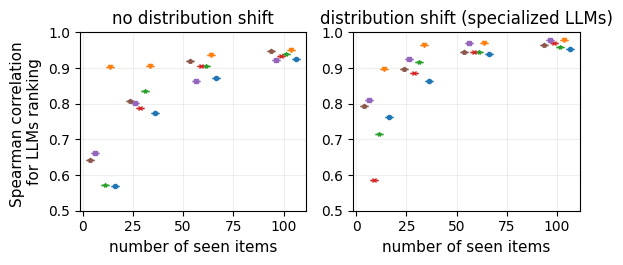

In [13]:
plt.figure(figsize=(6,2.75))
bench='mmlu_fields'
# Iterate over your benchmarks
for i, split in enumerate(splits):  # Replace `benchmarks` with your list of benchmarks
    # Plot on the ith subplot
    plt.subplot(1, 2, i+1)
    if results == 'rank': ylabel='Spearman correlation \nfor LLMs ranking'
    else: ylabel='score estimation error'
        
    plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                    title={'iid':'no distribution shift', 'noniid':'distribution shift (specialized LLMs)'}[split],
                    xlabel='number of seen items',
                    ylabel=ylabel, ylim=ylim, legend=False, error_bar=True, show_ylabel=split=='iid')
    plt.tight_layout()
plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

In [14]:
if agg == 'leaderboard':
    plt.figure(figsize=(.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(splits):
        ylabel_dic = {'iid':'(no distribution shift)', 'noniid':'(distribution shift)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'score estimation error\n{ylabel_dic[split]}'
  
        # Iterate over your benchmarks
        for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of seen items'
            else: xlabel='number of seen items (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(2, 4, 4*j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),
                            error_bar=True,show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/leaderboard_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

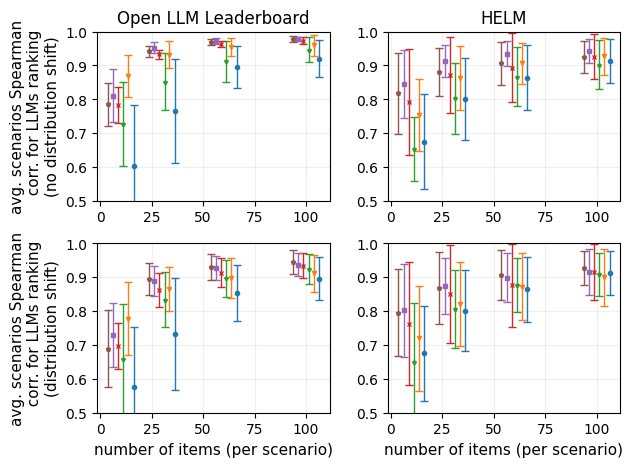

In [15]:
if agg == 'scenarios':
    plt.figure(figsize=(.5*.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)
    
    for j, split in enumerate(splits):
        # Create a figure and a set of subplots
        

        ylabel_dic = {'iid':'(no distribution shift)', 'noniid':'(distribution shift)'}
        
        if results == 'rank': ylabel=f'avg. scenarios Spearman\n  corr. for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'average scenarios score\n estimation error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(['lb','helm']):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of items'
            else: xlabel='number of items (per scenario)'    
            # Plot on the ith subplot
            plt.subplot(2, 2, 2*j +i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),error_bar=True,
                            show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/avg_scenarios_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

In [9]:
with open('results/samples_mmlu.pickle', 'rb') as handle:
    sample_data = pickle.load(handle)

In [10]:
iteration = 1
number_item = 100

In [11]:
w = sample_data['item_weights']['anchor-irt'][number_item][iteration]['mmlu']

1/(w.shape[0]*np.sum((w)**2)), w.max()

(0.9251314895262486, 0.024701724820600304)

In [12]:
with open('data/lb.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
#scenarios
scenarios = lb_scenarios
scenarios = {'mmlu':scenarios['mmlu']}
chosen_scenarios = ['mmlu']

In [13]:
# Prepare data and scenarios
scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
#scores = create_responses(chosen_scenarios, scenarios, data)

In [14]:
points_per_sub = {'sub':scenarios['mmlu']}

for it in range(len(sample_data['seen_items']['anchor-irt'][number_item])):
    seen_data = sample_data['seen_items']['anchor-irt'][number_item][it]
    points_per_sub['n_'+str(it)]=[np.sum([True for s in seen_data if s in subscenarios_position['mmlu'][sub]]) for sub in scenarios['mmlu']]

In [15]:
df = pd.DataFrame(points_per_sub)

In [16]:
df['n_avg'] = df.iloc[:,1:].mean(axis=1)
df['n_std'] = df.iloc[:,1:].std(axis=1)

In [17]:
df.sort_values(by=['n_avg'], ascending=False)

,sub,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,n_avg,n_std
48,harness_hendrycksTest_professional_law_5,6.0,3.0,7.0,4.0,9.0,9.0,8.0,9.0,6.0,7.0,6.8,1.989975
41,harness_hendrycksTest_miscellaneous_5,4.0,5.0,7.0,5.0,6.0,6.0,4.0,7.0,7.0,9.0,6.0,1.483240
43,harness_hendrycksTest_moral_scenarios_5,5.0,4.0,5.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.5,0.500000
26,harness_hendrycksTest_high_school_microeconomi...,5.0,3.0,2.0,8.0,5.0,3.0,4.0,2.0,2.0,5.0,3.9,1.813836
4,harness_hendrycksTest_clinical_knowledge_5,4.0,3.0,4.0,4.0,6.0,3.0,3.0,4.0,3.0,2.0,3.6,1.019804
50,harness_hendrycksTest_professional_psychology_5,3.0,1.0,3.0,3.0,3.0,1.0,4.0,5.0,7.0,2.0,3.2,1.720465
52,harness_hendrycksTest_security_studies_5,3.0,4.0,1.0,4.0,2.0,6.0,2.0,2.0,4.0,3.0,3.1,1.374773
45,harness_hendrycksTest_philosophy_5,3.0,3.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,0.774597
28,harness_hendrycksTest_high_school_psychology_5,3.0,1.0,6.0,4.0,1.0,2.0,2.0,7.0,3.0,1.0,3.0,2.000000
29,harness_hendrycksTest_high_school_statistics_5,3.0,1.0,6.0,1.0,1.0,3.0,5.0,1.0,2.0,2.0,2.5,1.688194


In [18]:
subs = list(subscenarios_position['mmlu'].keys())

In [19]:
from sklearn.cluster import KMeans 
from sklearn.metrics import  silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances

In [20]:
E = sample_data['A'].squeeze() #np.hstack((sample_data['A'], sample_data['B'])).squeeze()
E = E.T#[:y.shape[0]]
scaled_E = StandardScaler().fit_transform(E)
E.shape

(14042, 10)

In [21]:
D = -np.ones((len(subs),len(subs)))
1

1

In [22]:
for i in tqdm(range(len(subs))):
    for j in range(len(subs)):
        X = E[subscenarios_position['mmlu'][subs[i]]].mean(axis=0)
        Y = E[subscenarios_position['mmlu'][subs[j]]].mean(axis=0)
        D[i,j] = np.sqrt(((X-Y)**2).sum())
        #D[i,j] = pairwise_distances(X, Y, metric='euclidean').mean()

100%|████████████████████████████████████████████| 57/57 [00:00<00:00, 246.72it/s]


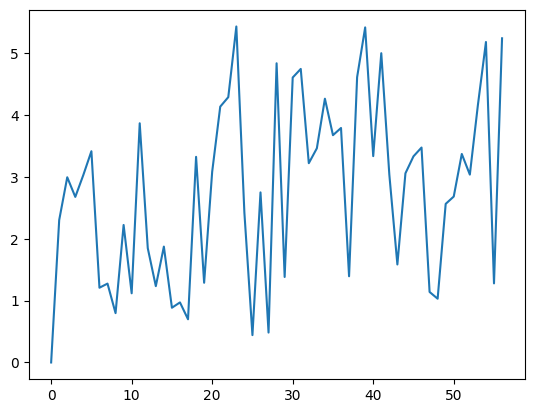

In [23]:
plt.plot(D[0])

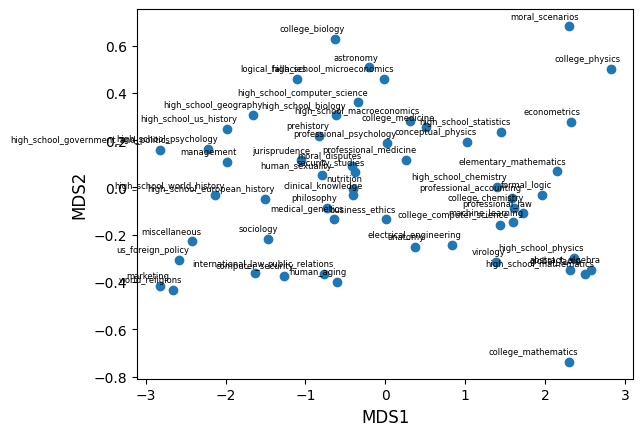

In [24]:
#Transforming D
n=D.shape[0]
e=np.ones(n).reshape((-1,1))
P=np.diag(e.squeeze())-e@e.T/n
M=-(P@D**2@P)/2

#
V, U=np.linalg.eigh(M)
V=np.sqrt(np.array(V[::-1])[:2])
U=np.array(U[:,::-1])[:,:2]

plt.scatter(V[0]*U[:,0], V[1]*U[:,1])
for i in range(n):
    plt.annotate(subs[i][22:-2], xy=(V[0]*U[:,0][i], V[1]*U[:,1][i]), xytext=(7, 4), fontsize = 6,
                 textcoords='offset points', ha='right', va='bottom')
    
plt.xlabel('MDS1', size=12)
plt.ylabel('MDS2', size=12)
plt.show()

100%|███████████████████████████████████████████████| 8/8 [00:22<00:00,  2.75s/it]


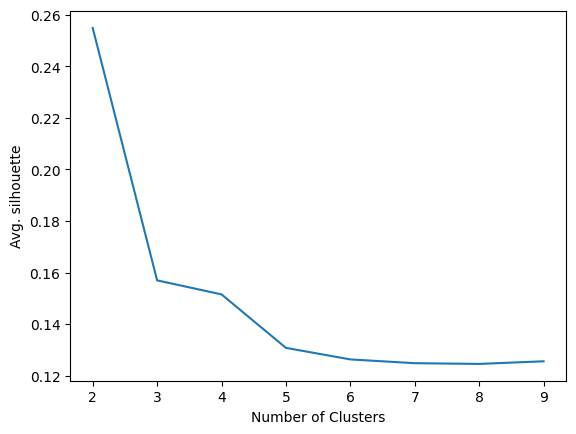

In [25]:
sill = []

for i in tqdm(range(2, 10)):
    kmeans = KMeans(n_clusters = i, random_state=0, n_init='auto', verbose=0)
    kmeans.fit(E)
    cluster_labels = kmeans.predict(E)

    sill.append(silhouette_score(E, cluster_labels))
    
plt.plot(range(2, 2+i-1), sill)
plt.xlabel('Number of Clusters')
plt.ylabel('Avg. silhouette') 
plt.show()

In [26]:
with open(f'data/lb.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
   
scenarios_position, subscenarios_position = prepare_data(scenarios, scenarios, data2)
scores = create_responses(scenarios, scenarios, data2)
        
balance_weights = np.ones(scores.shape[1]) #for scenario=='civil_comments', some items need to be downweighted, for other scenarios not
if 'civil_comments' in scenarios:
    balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
    scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)
if 'mmlu' in scenarios:
    N = len(scenarios_position['mmlu'])
    n_sub = len(scenarios['mmlu'])
    for sub in scenarios['mmlu']:
        n_i = len(subscenarios_position['mmlu'][sub])
        balance_weights[subscenarios_position['mmlu'][sub]] = N/(n_sub*n_i)

100%|███████████████████████████████████████████████| 8/8 [00:22<00:00,  2.75s/it]


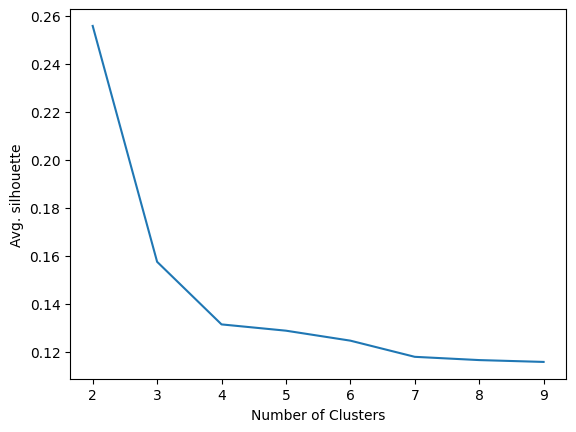

In [27]:
sill = []

for i in tqdm(range(2, 10)):
    kmeans = KMeans(n_clusters = i, random_state=0, n_init='auto', verbose=0)
    kmeans.fit(E, sample_weight=balance_weights)
    cluster_labels = kmeans.predict(E)

    sill.append(silhouette_score(E, cluster_labels))
    
plt.plot(range(2, 2+i-1), sill)
plt.xlabel('Number of Clusters')
plt.ylabel('Avg. silhouette') 
plt.show()

In [28]:
y=[]
for i,sub in enumerate(subs):
    y+=len(subscenarios_position['mmlu'][sub])*[i]
    
y = np.array(y)
y.shape

(14042,)

In [29]:
reordered_E = []
for i,sub in enumerate(subs):
    reordered_E.append(E[subscenarios_position['mmlu'][sub]])

In [30]:
reordered_E = np.vstack(reordered_E)
reordered_E.shape

(14042, 10)

In [31]:
#!pip install umap-learn
import umap

import umap.plot

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(
/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [32]:
%%time
reducer = umap.UMAP(verbose=True, repulsion_strength=1)
manifold = umap.UMAP().fit(scaled_E, y)

CPU times: user 14min 5s, sys: 23.4 s, total: 14min 29s
Wall time: 43.5 s


<Axes: >

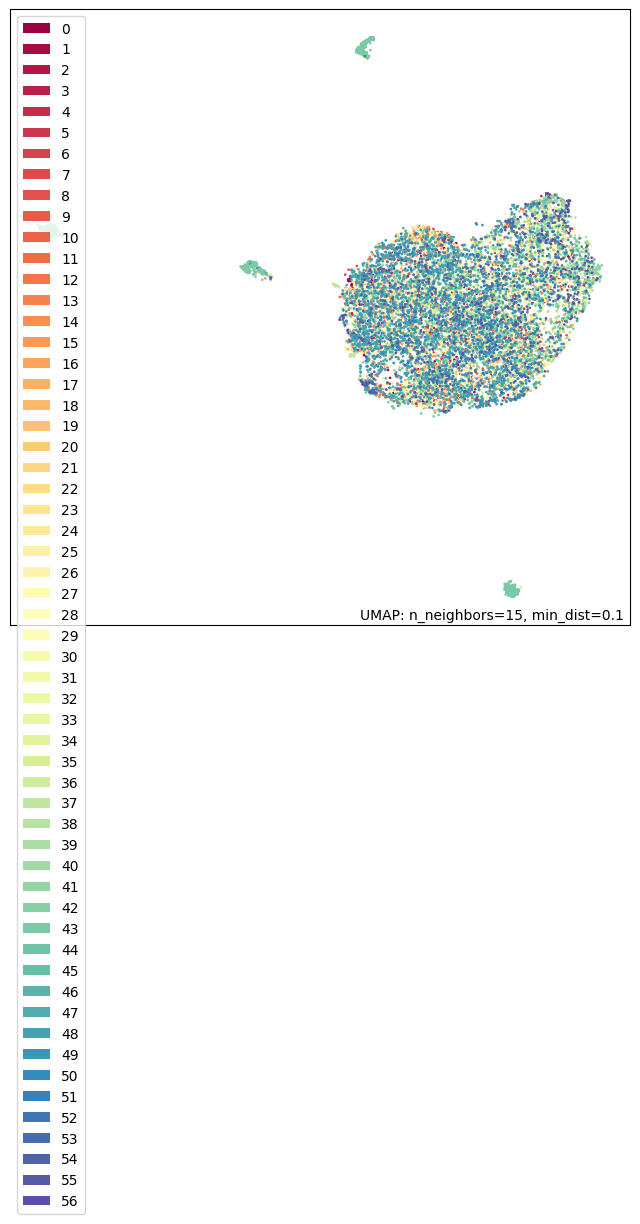

In [33]:
umap.plot.points(manifold, labels=y)

<Axes: >

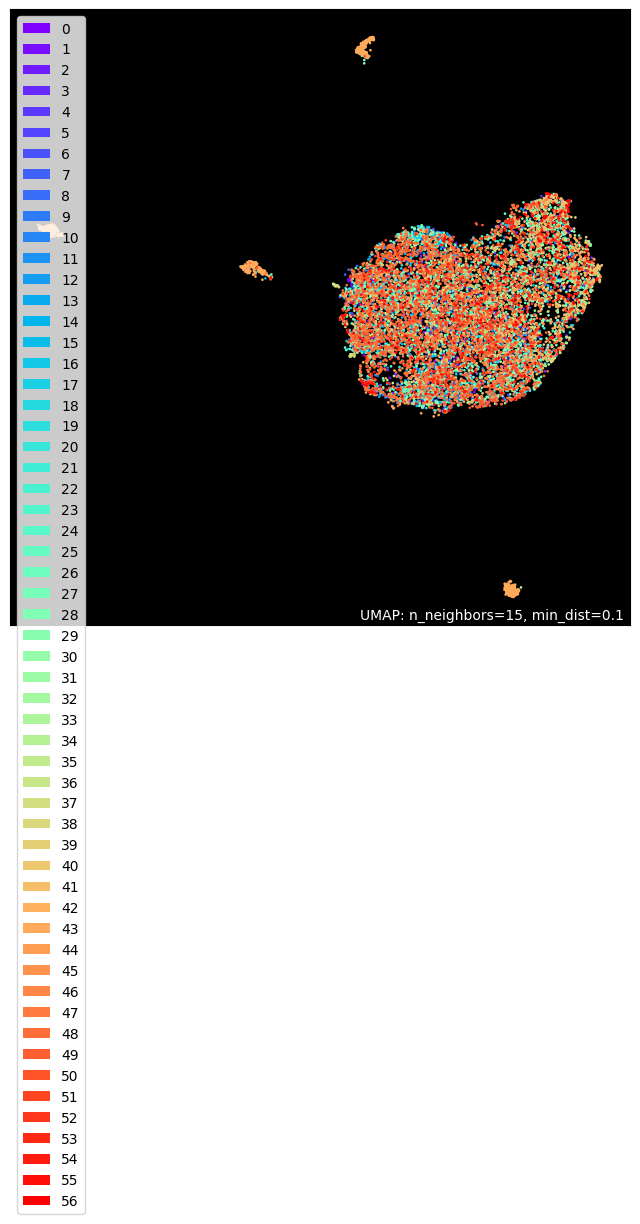

In [34]:
umap.plot.points(manifold, labels=y, theme="fire")

<Axes: >

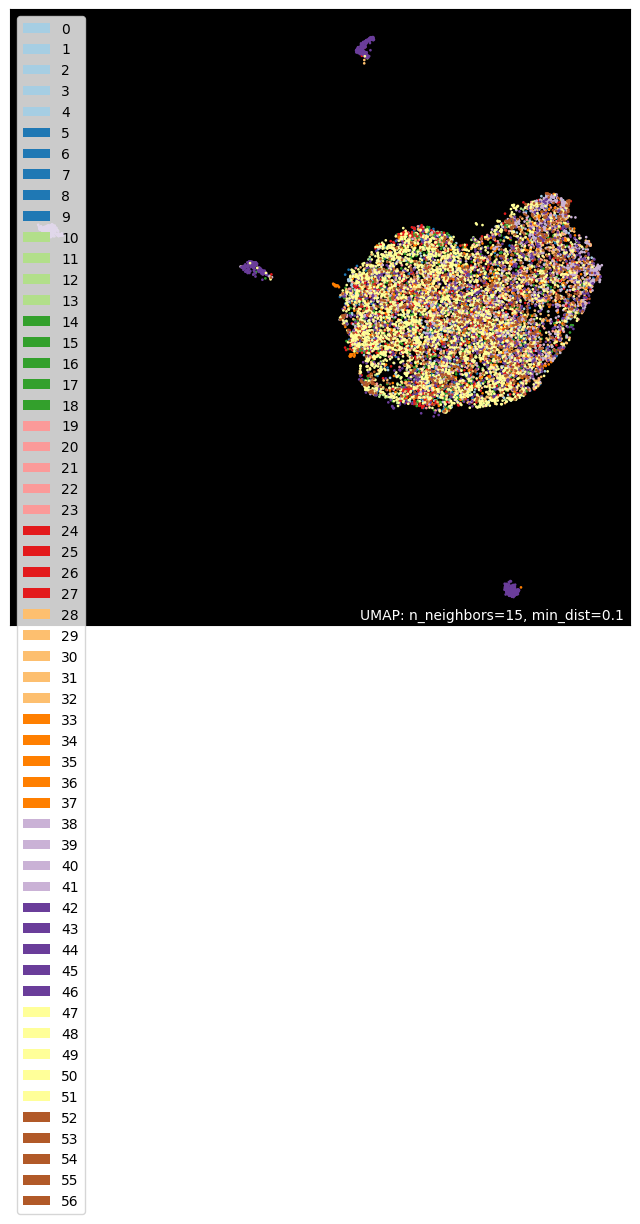

In [35]:
umap.plot.points(manifold, labels=y, color_key_cmap='Paired', background='black')

In [36]:
%%time
reducer = umap.UMAP(verbose=True, repulsion_strength=1)
manifold = umap.UMAP().fit(reordered_E, y)

CPU times: user 14min 39s, sys: 5.22 s, total: 14min 44s
Wall time: 29.6 s


<Axes: >

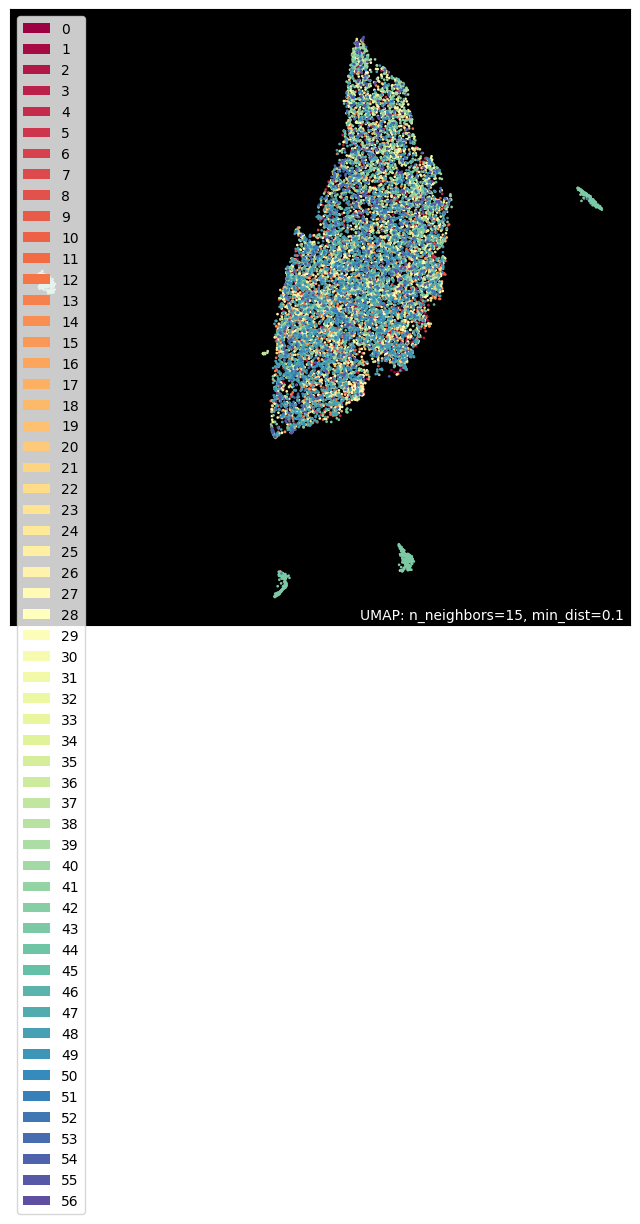

In [37]:
umap.plot.points(manifold, labels=y, background='black')

<Axes: >

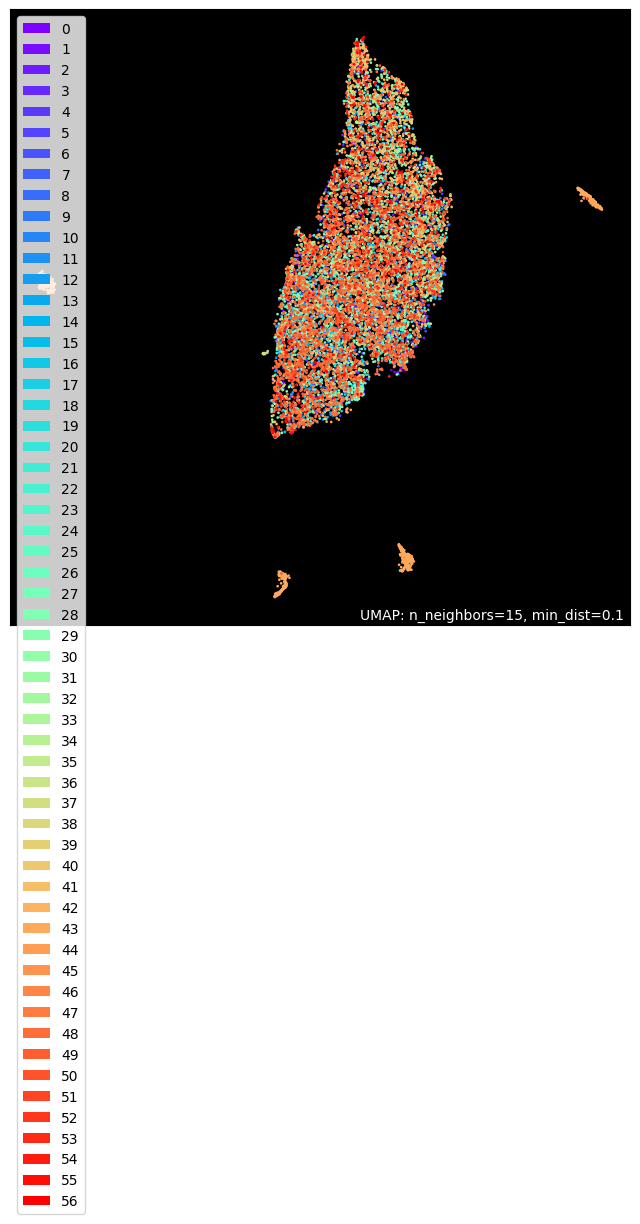

In [38]:
umap.plot.points(manifold, labels=y, theme="fire")

<Axes: >

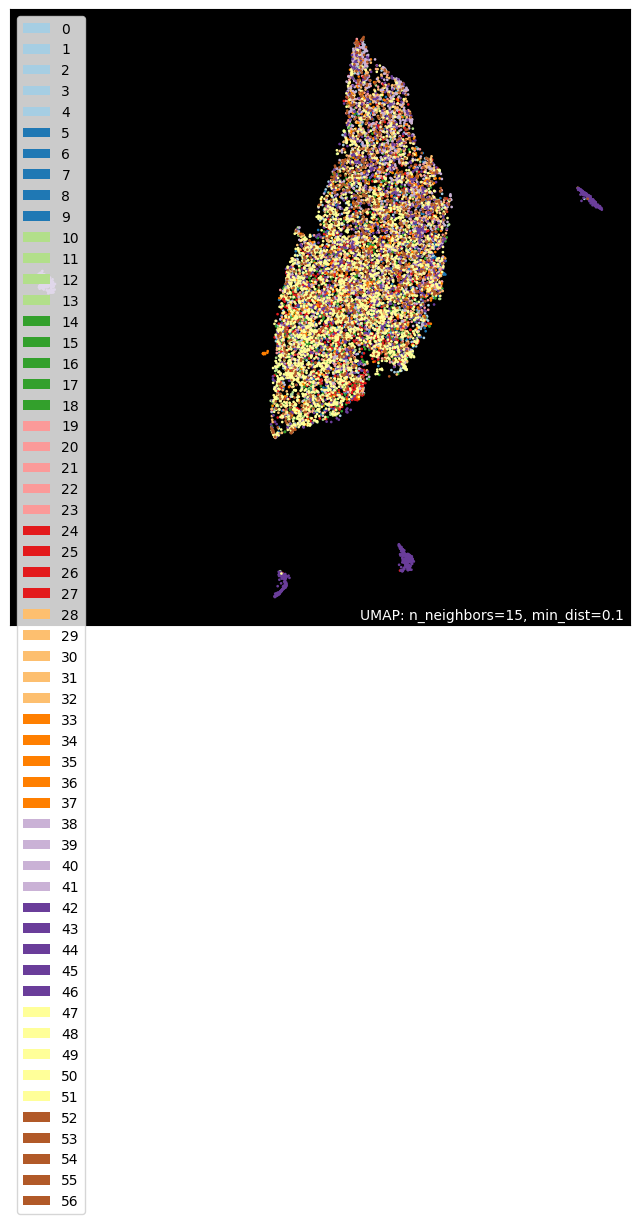

In [39]:
umap.plot.points(manifold, labels=y, color_key_cmap='Paired', background='black')

In [40]:
umap.plot.connectivity(manifold, edge_bundling='hammer')

/home/skunk/miniconda3/envs/efficbench/lib/python3.11/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(

KeyboardInterrupt

